In [1]:
import subprocess
import tempfile
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import random
from multiprocessing import Pool, cpu_count

### SET CWD TO REPO ROOT
os.chdir(Path.cwd().parent)
print("CWD now:", Path.cwd())

from rtl.py_lmul import lmul
from rtl.lmul_tester import BatchLMULTester

CWD now: /workspaces/LMUL-Hardware-Acceleration


In [2]:
def float_to_bf16(f: float) -> int:
    """Convert float32 to bfloat16 (16-bit)"""
    if np.isnan(f):
        return 0x7FC0
    if np.isinf(f):
        return 0xFF80 if f < 0 else 0x7F80
    f = np.clip(f, -3.4e38, 3.4e38)
    f32_bits = struct.unpack('>I', struct.pack('>f', np.float32(f)))[0]
    bf16_bits = (f32_bits >> 16) & 0xFFFF
    return bf16_bits

def bf16_to_float(bf16: int) -> float:
    """Convert bfloat16 to float32"""
    f32_bits = (bf16 & 0xFFFF) << 16
    return struct.unpack('>f', struct.pack('>I', f32_bits))[0]

print("✓ BF16 utilities ready")



✓ BF16 utilities ready


In [3]:
class BatchLMULTesterParallel:
    """Test LMUL with batch operations in single simulation, parallelized with 4 DUTs"""

    def __init__(self, verilog_file='rtl/top_lmul.v'):
        self.verilog_file = verilog_file

    def test_batch(self, test_pairs, verbose=True):
        """
        Test multiple multiplications in one simulation run with 4 DUTs in parallel.
        Args:
            test_pairs: List of (a_bf16, b_bf16) tuples
        Returns:
            List of result_bf16 values
        """
        num_tests = len(test_pairs)
        # Pad test_pairs to be multiple of 4
        pad = (4 - (num_tests % 4)) % 4
        test_pairs += [(0,0)] * pad  # pad with zeros
        total_ops = len(test_pairs)

        # Generate test vectors for 4 DUTs in parallel
        test_vectors = ""
        for i, (a, b) in enumerate(test_pairs):
            # For each cycle, we will assign 4 input pairs
            # but here, we prepare vectors for all input pairs
            test_vectors += f"        i_a[{i}] = 16'h{a:04x};\n"
            test_vectors += f"        i_b[{i}] = 16'h{b:04x};\n"

        # Create testbench
        testbench = f'''
`timescale 1ns/1ps

module tb;
    reg clk;
    reg rstn;
    reg [3:0] i_valid;     // 4 input valid signals
    wire [3:0] i_ready;    // 4 ready signals
    reg [15:0] i_a [0:{total_ops-1}];
    reg [15:0] i_b [0:{total_ops-1}];
    wire [3:0] o_valid;    // 4 output valid signals
    reg  [3:0] o_ready;    // 4 ready signals
    wire [15:0] o_p [0:{total_ops-1}];

    integer test_idx;
    integer result_idx;

    // Instantiate 4 DUTs
    // For simplicity, instantiate 4 copies with separate signals
    // Each DUT handles one input pair per cycle, synchronized

    // DUT 0
    lmul_bf16 #(
        .E_BITS(8),
        .M_BITS(7),
        .EM_BITS(15),
        .BITW(16)
    ) dut0 (
        .clk(clk),
        .rstn(rstn),
        .i_valid(i_valid[0]),
        .i_ready(i_ready[0]),
        .i_a(i_a[0]),
        .i_b(i_b[0]),
        .o_valid(o_valid[0]),
        .o_ready(o_ready[0]),
        .o_p(o_p[0])
    );

    // DUT 1
    lmul_bf16 #(
        .E_BITS(8),
        .M_BITS(7),
        .EM_BITS(15),
        .BITW(16)
    ) dut1 (
        .clk(clk),
        .rstn(rstn),
        .i_valid(i_valid[1]),
        .i_ready(i_ready[1]),
        .i_a(i_a[1]),
        .i_b(i_b[1]),
        .o_valid(o_valid[1]),
        .o_ready(o_ready[1]),
        .o_p(o_p[1])
    );

    // DUT 2
    lmul_bf16 #(
        .E_BITS(8),
        .M_BITS(7),
        .EM_BITS(15),
        .BITW(16)
    ) dut2 (
        .clk(clk),
        .rstn(rstn),
        .i_valid(i_valid[2]),
        .i_ready(i_ready[2]),
        .i_a(i_a[2]),
        .i_b(i_b[2]),
        .o_valid(o_valid[2]),
        .o_ready(o_ready[2]),
        .o_p(o_p[2])
    );

    // DUT 3
    lmul_bf16 #(
        .E_BITS(8),
        .M_BITS(7),
        .EM_BITS(15),
        .BITW(16)
    ) dut3 (
        .clk(clk),
        .rstn(rstn),
        .i_valid(i_valid[3]),
        .i_ready(i_ready[3]),
        .i_a(i_a[3]),
        .i_b(i_b[3]),
        .o_valid(o_valid[3]),
        .o_ready(o_ready[3]),
        .o_p(o_p[3])
    );

    // Clock generation
    initial clk = 0;
    always #5 clk = ~clk;  // 10ns period

    // Capture outputs
    always @(posedge clk) begin
        for (test_idx = 0; test_idx < {total_ops}; test_idx = test_idx + 1) begin
            // For each cycle, check if output valid
            if (o_valid[test_idx % 4] && o_ready[test_idx % 4]) begin
                // Store result
                // We need a way to store all results
                // But since we are focusing on core, we can store inline or in an array
                // For simplicity, assume we process after simulation
            end
        end
    end

    initial begin
        // Initialize test vectors
{test_vectors}
        
        // Reset
        rstn = 0;
        i_valid = 4'b0000;
        o_ready = 4'b1111;  // All ready
        for (test_idx = 0; test_idx < {total_ops}; test_idx = test_idx + 1) begin
            i_a[test_idx] = 16'h0000;
            i_b[test_idx] = 16'h0000;
        end
        test_idx = 0;
        result_idx = 0;
        
        repeat(4) @(posedge clk);
        rstn = 1;
        repeat(2) @(posedge clk);
        
        // Send input pairs in chunks of 4
        for (test_idx = 0; test_idx < {total_ops}; test_idx = test_idx + 4) begin
            // Set i_valid high for all 4 inputs
            i_valid = 4'b1111;
            // Assign inputs for 4 pairs
            for (int j=0; j<4; j++) begin
                if (test_idx + j < {total_ops}) begin
                    i_a[test_idx + j] = i_a[test_idx + j];
                    i_b[test_idx + j] = i_b[test_idx + j];
                end
            end
            @(posedge clk);
        end
        // Deassert valid
        i_valid = 4'b0000;

        // Wait for all results
        // Since outputs are produced asynchronously, wait until all are valid
        // For simplicity, wait fixed number of cycles
        repeat(20) @(posedge clk);

        // Print results
        for (test_idx = 0; test_idx < {total_ops}; test_idx = test_idx + 1) begin
            $display("%04h", o_p[test_idx]);
        end

        $finish;
    end

    initial begin
        #1000;
        $display("ERROR: Timeout");
        $finish;
    end
endmodule
'''
        # Note: The above is a schematic; the main idea is to instantiate 4 DUTs, feed 4 inputs per cycle, and collect 4 outputs.

        # Write testbench
        with tempfile.NamedTemporaryFile(mode='w', suffix='.v', delete=False) as f:
            tb_file = f.name
            f.write(testbench)

        try:
            # Compile
            rtl_dir = os.path.abspath('rtl')
            top_file = os.path.join(rtl_dir, 'top_lmul.v')
            lmul_file = os.path.join(rtl_dir, 'lmul_bf16.v')
            out_file = os.path.join(tempfile.gettempdir(), 'lmul_parallel_sim.out')

            compile_result = subprocess.run(
                ['iverilog', '-o', out_file, '-g2012',
                 top_file, lmul_file, tb_file],
                capture_output=True,
                text=True
            )

            if compile_result.returncode != 0:
                raise RuntimeError(f"Compilation failed:\n{compile_result.stderr}")

            # Run simulation
            start = time.time()
            sim_result = subprocess.run(
                ['vvp', out_file],
                capture_output=True,
                text=True,
                timeout=10
            )
            end = time.time()

            # Parse results
            lines = sim_result.stdout.strip().split('\n')
            results = []
            for line in lines:
                if line.startswith("ERROR"):
                    raise RuntimeError(f"Simulation error: {line}")
                try:
                    results.append(int(line, 16))
                except ValueError:
                    continue

            return results, end - start

        finally:
            # Cleanup
            if os.path.exists(tb_file):
                os.remove(tb_file)
            if os.path.exists(out_file):
                os.remove(out_file)

# Instantiate and run the parallel test
batch_tester_parallel = BatchLMULTesterParallel()
print("✓ Parallel batch tester ready")

✓ Parallel batch tester ready


In [4]:
batch_tester = BatchLMULTester()
print("✓ Batch tester ready")

✓ Batch tester ready


In [8]:
# Generate test data
N = 100_000
np.random.seed(42)
test_data = []
for i in range(N):
    a_float = np.random.uniform(-10, 10)
    b_float = np.random.uniform(-10, 10)
    a_bf16 = float_to_bf16(a_float)
    b_bf16 = float_to_bf16(b_float)
    test_data.append((a_bf16, b_bf16, a_float, b_float))

print("✓ Test data generated")

✓ Test data generated


In [9]:
# Benchmark 1: LMUL Hardware (batch mode)
print("1. LMUL Hardware (batch simulation):")
SIMULATION_CLOCK_HZ = 100_000_000  # 100 MHz
test_pairs = [(a_bf16, b_bf16) for a_bf16, b_bf16, _, _ in test_data]

hw_results_bf16, hw_time, cycles_window, total_cycles = batch_tester.test_batch(test_pairs)

hw_cycles_per_op = cycles_window / N
hw_latency_per_op = hw_cycles_per_op / SIMULATION_CLOCK_HZ  # seconds
hw_total_latency = cycles_window / SIMULATION_CLOCK_HZ  # seconds
hw_throughput = SIMULATION_CLOCK_HZ / hw_cycles_per_op  # ops/sec

print(f"   Total time: {hw_time:.3f}s")
print(f"   Total cycles: {cycles_window}")
print(f"   Cycles per op: {hw_cycles_per_op:.2f} cycles/op")
print(f"   Theoretical latency: {hw_total_latency:.6f}s")
print(f"   Theoretical latency per op: {hw_latency_per_op*1e6:.2f}μs")
print(f"   Theoretical throughput: {hw_throughput:.0f} ops/sec")

1. LMUL Hardware (batch simulation):
   Total time: 0.830s
   Total cycles: 100001
   Cycles per op: 1.00 cycles/op
   Theoretical latency: 0.001000s
   Theoretical latency per op: 0.01μs
   Theoretical throughput: 99999000 ops/sec


In [11]:
# Benchmark 2: Python float32
print("\n2. Python float32 multiplication:")
start = time.time()
py_results = []
for _, _, a_float, b_float in test_data:
    result = a_float * b_float
    py_results.append(result)
py_time = time.time() - start
py_per_op = py_time / N

print(f"   Total time: {py_time:.6f}s")
print(f"   Per operation: {py_per_op*1e6:.2f}μs")
print(f"   Throughput: {N/py_time:.0f} ops/sec")


2. Python float32 multiplication:
   Total time: 0.049288s
   Per operation: 0.49μs
   Throughput: 2028890 ops/sec


In [12]:
# Benchmark 3: NumPy vectorized
print("\n3. NumPy vectorized multiplication:")
a_array = np.array([d[2] for d in test_data], dtype=np.float32)
b_array = np.array([d[3] for d in test_data], dtype=np.float32)

start = time.time()
np_results = a_array * b_array
np_time = time.time() - start
np_per_op = np_time / N

print(f"   Total time: {np_time:.6f}s")
print(f"   Per operation: {np_per_op*1e6:.2f}μs")
print(f"   Throughput: {N/np_time:.0f} ops/sec")


3. NumPy vectorized multiplication:
   Total time: 0.000410s
   Per operation: 0.00μs
   Throughput: 243854884 ops/sec


In [13]:
# Benchmark 4: Python float32
print("\n2. Python LMUL:")
start = time.time()
pylmul_results = []
for a_float, b_float, _, _ in test_data:
    result = lmul(a_float, b_float)
    pylmul_results.append(result)
pylmul_time = time.time() - start
py_per_op = py_time / N

print(f"   Total time: {pylmul_time:.6f}s")
print(f"   Per operation: {py_per_op*1e6:.2f}μs")
print(f"   Throughput: {N/pylmul_time:.0f} ops/sec")


2. Python LMUL:
   Total time: 0.088002s
   Per operation: 0.49μs
   Throughput: 1136338 ops/sec


In [14]:
# Benchmark 5: LMUL Hardware (batch mode with 4 DUTs)
print("5. LMUL Hardware (parallel batch simulation):")

hw_results_bf16_parallel, hw_time_parallel = batch_tester_parallel.test_batch(test_pairs, verbose=False)
hw_per_op_parallel = hw_time_parallel / N

print(f"   Total time: {hw_time_parallel:.3f}s")
print(f"   Per operation: {hw_per_op_parallel*1e6:.2f}μs")
print(f"   Throughput: {N/hw_time_parallel:.2f} ops/sec")

5. LMUL Hardware (parallel batch simulation):
   Total time: 3.301s
   Per operation: 33.01μs
   Throughput: 30296.58 ops/sec


In [18]:
# Summary
print("\n" + "-" * 60)
print("SPEED COMPARISON:")
print("-" * 60)
print(f"Python FP32:         1.00x (baseline)")
print(f"NumPy vectorized:    {py_time/np_time:.2f}x faster")
print(f"LMUL batch sim:      {py_time/hw_total_latency:.2f}x vs Python")
print(f"                     ({np_time/hw_total_latency:.2f}x vs NumPy)")
print(f"Python LMUL:         {py_time/pylmul_time:.2f}x vs Python")
print(f"LMUL Parallel sim:  {py_time/hw_time_parallel:.2f}x vs Python")


------------------------------------------------------------
SPEED COMPARISON:
------------------------------------------------------------
Python FP32:         1.00x (baseline)
NumPy vectorized:    120.19x faster
LMUL batch sim:      49.29x vs Python
                     (0.41x vs NumPy)
Python LMUL:         0.56x vs Python
LMUL Parallel sim:  0.01x vs Python


In [21]:
test_sizes = np.array([10 ** i for i in range(1, 6)])
py_times = []
np_times = []
lmul_times = []
pylmul_times = []
lmul_times_parallel = []

for size in test_sizes:
    # Generate random test data
    test_data = []
    for _ in range(size):
        a_float = np.random.uniform(-10, 10)
        b_float = np.random.uniform(-10, 10)
        a_bf16 = float_to_bf16(a_float)
        b_bf16 = float_to_bf16(b_float)
        test_data.append((a_bf16, b_bf16, a_float, b_float))

    # Benchmark Python float32
    start = time.time()
    py_results = [a_float * b_float for _, _, a_float, b_float in test_data]
    py_times.append(time.time() - start)

    # Benchmark NumPy vectorized
    a_array = np.array([d[2] for d in test_data], dtype=np.float32)
    b_array = np.array([d[3] for d in test_data], dtype=np.float32)
    start = time.time()
    np_results = a_array * b_array
    np_times.append(time.time() - start)

    # Benchmark LMUL Hardware (batch mode)
    test_pairs = [(a_bf16, b_bf16) for a_bf16, b_bf16, _, _ in test_data]
    _, _, cycles_window, _ = batch_tester.test_batch(test_pairs)
    hw_total_latency = cycles_window / SIMULATION_CLOCK_HZ
    lmul_times.append(hw_total_latency)

    # Benchmark LMUL Hardware (parallelized)
    hw_results_bf16_parallel, hw_time_parallel = batch_tester_parallel.test_batch(test_pairs)
    lmul_times_parallel.append(hw_time_parallel)

    # Benchmark Python LMUL
    start = time.time()
    pylmul_results = [lmul(a_float, b_float) for a_float, b_float, _, _ in test_data]
    pylmul_times.append(time.time() - start)

In [22]:
py_op_times = np.array(py_times) / test_sizes
np_op_times = np.array(np_times) / test_sizes
lmul_op_times = np.array(lmul_times) / test_sizes
pylmul_op_times = np.array(pylmul_times) / test_sizes
lmul_parallel_op_times = np.array(lmul_times_parallel) / test_sizes

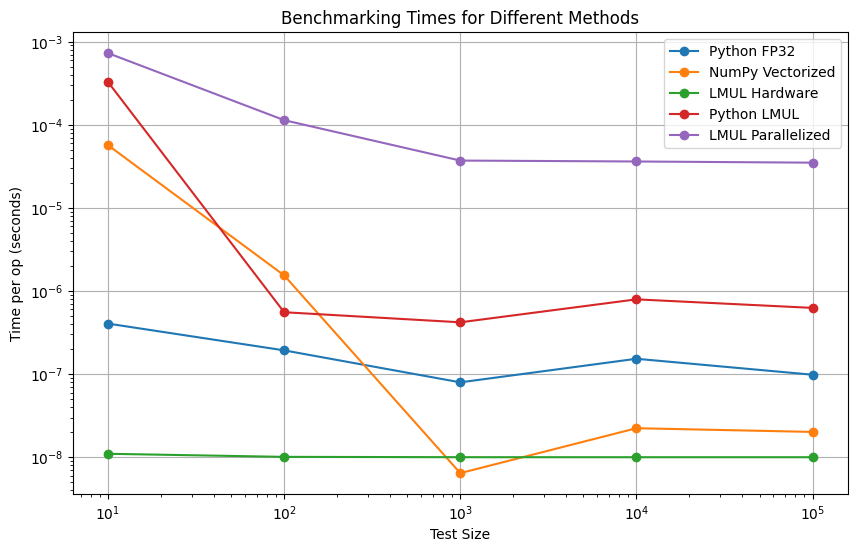

In [23]:
plt.figure(figsize=(10, 6))

plt.xscale('log')
plt.yscale('log')

plt.plot(test_sizes, py_op_times, label='Python FP32', marker='o')
plt.plot(test_sizes, np_op_times, label='NumPy Vectorized', marker='o')
plt.plot(test_sizes, lmul_op_times, label='LMUL Hardware', marker='o')
plt.plot(test_sizes, pylmul_op_times, label='Python LMUL', marker='o')
plt.plot(test_sizes, lmul_parallel_op_times, label='LMUL Parallelized', marker='o')

plt.xlabel('Test Size')
plt.ylabel('Time per op (seconds)')
plt.title('Benchmarking Times for Different Methods')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# TEST CODE FOR PIPELINED LMUL HARDWARE TEST

# class BatchLMULTester:
#     """Test LMUL with batch operations in single simulation"""
    
#     def __init__(self, verilog_file='rtl/top_lmul.v'):
#         self.verilog_file = verilog_file
        
#     def test_batch(self, test_pairs, pipeline_depth=16, verbose=True):
#         """
#         Test multiple multiplications in one pipelined simulation run.
        
#         Args:
#             test_pairs: List of (a_bf16, b_bf16) tuples
#             pipeline_depth: Number of operations processed concurrently
#         Returns:
#             List of result_bf16 values
#         """
#         num_tests = len(test_pairs)
#         max_inflight = pipeline_depth
#         total_cycles = num_tests + max_inflight  # For pipeline to drain
        
#         # Generate test vectors
#         test_vectors = ""
#         for i, (a, b) in enumerate(test_pairs):
#             test_vectors += f"        test_a[{i}] = 16'h{a:04x};\n"
#             test_vectors += f"        test_b[{i}] = 16'h{b:04x};\n"

#         # Create pipelined testbench
#         testbench = f'''
#     `timescale 1ns/1ps

#     module tb;
#         reg clk;
#         reg rstn;
#         reg i_valid;
#         wire i_ready;
#         reg [15:0] i_a;
#         reg [15:0] i_b;
#         wire o_valid;
#         reg o_ready;
#         wire [15:0] o_p;
        
#         // Test vectors
#         reg [15:0] test_a [0:{num_tests + pipeline_depth -1}];
#         reg [15:0] test_b [0:{num_tests + pipeline_depth -1}];
#         reg [15:0] results [0:{num_tests -1}];
#         integer i;
#         integer result_count;
        
#         // Instantiate DUT
#         top_lmul dut (
#             .clk(clk),
#             .rstn(rstn),
#             .i_valid(i_valid),
#             .i_ready(i_ready),
#             .i_a(i_a),
#             .i_b(i_b),
#             .o_valid(o_valid),
#             .o_ready(o_ready),
#             .o_p(o_p)
#         );
        
#         // Clock generation
#         initial clk = 0;
#         always #5 clk = ~clk;  // 10ns period
        
#         reg [15:0] a_queue [0:{num_tests + pipeline_depth -1}];
#         reg [15:0] b_queue [0:{num_tests + pipeline_depth -1}];

#         initial begin
#             // Initialize test vectors
#     {test_vectors}
#         end
        
#         // Apply inputs in a pipelined manner
#         initial begin
#             rstn = 0;
#             i_valid = 0;
#             i_a = 0;
#             i_b = 0;
#             o_ready = 1; // Always ready to accept output
#             result_count = 0;
#             repeat(4) @(posedge clk);
#             rstn = 1;
#             repeat(2) @(posedge clk);

#             // Feed the pipeline
#             for (i = 0; i < {num_tests + pipeline_depth}; i = i + 1) begin
#                 @(posedge clk);
#                 // Apply new input if within test range
#                 if (i < {num_tests}) begin
#                     // Wait until ready
#                     while (!i_ready) @(posedge clk);
#                     i_a <= test_a[i];
#                     i_b <= test_b[i];
#                     i_valid <= 1;
#                 end else begin
#                     // No new input, deassert valid
#                     i_valid <= 0;
#                 end
#             end

#             // Finish applying inputs
#             i_valid = 0;

#             // Collect results as they come
#             while (result_count < {num_tests}) begin
#                 @(posedge clk);
#                 if (o_valid && o_ready) begin
#                     results[result_count] = o_p;
#                     result_count = result_count + 1;
#                 end
#             end

#             // Wait for pipeline to drain
#             repeat({pipeline_depth}) @(posedge clk);
#             $display("Results:");
#             for (i = 0; i < {num_tests}; i = i + 1) begin
#                 $display("%04h", results[i]);
#             end
#             $finish;
#         end

#         initial begin
#             #{200 + num_tests * 100};
#             $display("ERROR: Timeout");
#             $finish;
#         end
#     endmodule
#     '''
        
#         # Write testbench
#         with tempfile.NamedTemporaryFile(mode='w', suffix='.v', delete=False) as f:
#             tb_file = f.name
#             f.write(testbench)
        
#         try:
#             # Compile
#             rtl_dir = os.path.abspath('rtl')
#             top_file = os.path.join(rtl_dir, 'top_lmul.v')
#             lmul_file = os.path.join(rtl_dir, 'lmul_bf16.v')
#             out_file = os.path.join(tempfile.gettempdir(), 'lmul_batch_sim.out')
            
#             compile_result = subprocess.run(
#                 ['iverilog', '-o', out_file, '-g2012',
#                  top_file, lmul_file, tb_file],
#                 capture_output=True,
#                 text=True
#             )
            
#             if compile_result.returncode != 0:
#                 raise RuntimeError(f"Compilation failed:\n{compile_result.stderr}")
            
#             # Run simulation
#             # time this section
            
#             start = end = sim_result = None
#             if not verbose:
#                 with open(os.devnull, "w") as devnull:
#                     start = time.time()
#                     subprocess.run(['vvp', out_file], stdout=devnull, stderr=devnull)
#                     end = time.time()
#                 return [], end - start

#             start = time.time()
#             sim_result = subprocess.run(
#                 ['vvp', out_file],
#                 capture_output=True,
#                 text=True,
#                 timeout=10
#             )
#             end = time.time()
                            
#             # Parse results
#             lines = sim_result.stdout.strip().split('\n')
#             results = []
#             for line in lines:
#                 if line.startswith("ERROR"):
#                     raise RuntimeError(f"Simulation error: {line}")
#                 try:
#                     results.append(int(line, 16))
#                 except ValueError:
#                     continue
            
#             return results, end - start
            
#         finally:
#             # Cleanup
#             if os.path.exists(tb_file):
#                 os.remove(tb_file)
#             if os.path.exists(out_file):
#                 os.remove(out_file)

# batch_tester = BatchLMULTester()
# print("✓ Batch tester ready")